In [ ]:
!pip install rouge-score nltk

In [ ]:
!pip install -U bitsandbytes
# !pip install accelerate bitsandbytes
# !pip install bitsandbytes-cuda110 bitsandbytes

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from accelerate import init_empty_weights
import gc
import psutil
import numpy as np
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time  # Added missing import
from typing import Dict, List, Tuple

Loading distilgpt2-medical...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Successfully loaded distilgpt2-medical

Starting evaluation...

=== distilgpt2-medical Output for Case 1 ===

Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
           Animate history (see below) is a physical examination that has been performed to confirm or estimate any symptoms associated from an individual's initial exposure during use in this area prior on their own so as not to cause further risk for future exposures later than before.[1] A person can be diagnosed by using inhalation equipment such Asperger’s Breathalyzer if there have ever bee

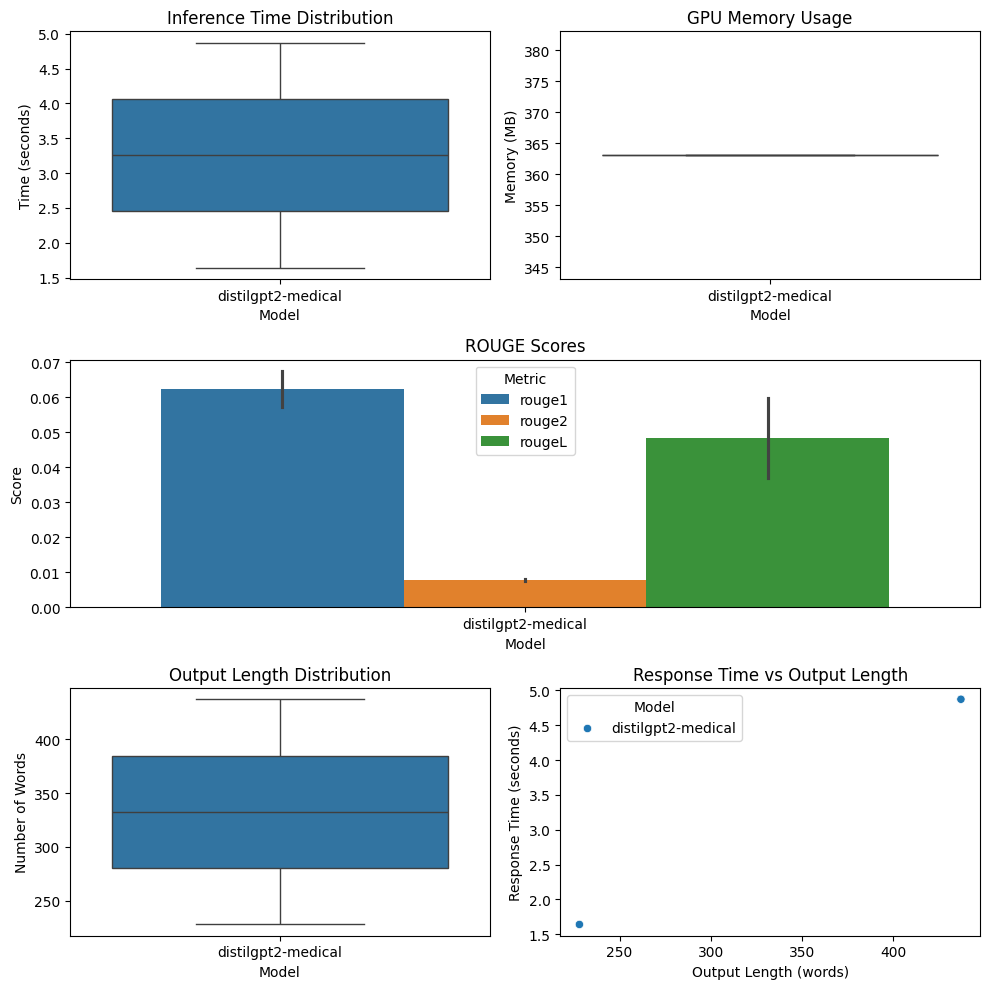

In [10]:
class ModelLoader:
    def __init__(self):
        self.models = {}
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

    def load_models(self):
        model_configs = {
            'distilgpt2-medical': {
                'path': "Apurva3509/distilgpt2-medical-finetuned",
                'use_4bit': False
            }
        }

        for model_name, config in model_configs.items():
            try:
                print(f"Loading {model_name}...")

                gc.collect()
                torch.cuda.empty_cache()

                if config['use_4bit']:
                    model = AutoModelForCausalLM.from_pretrained(
                        config['path'],
                        quantization_config=self.quantization_config,
                        device_map="auto",
                        torch_dtype=torch.float16
                    )
                else:
                    model = AutoModelForCausalLM.from_pretrained(
                        config['path'],
                        torch_dtype=torch.float16
                    ).to('cuda')

                tokenizer = AutoTokenizer.from_pretrained(config['path'])

                if tokenizer.pad_token is None:
                    tokenizer.pad_token = tokenizer.eos_token

                self.models[model_name] = (model, tokenizer)
                print(f"Successfully loaded {model_name}")

            except Exception as e:
                print(f"Error loading {model_name}: {str(e)}")

        return self.models

class ModelEvaluator:
    def __init__(self, models):
        self.models = models
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def evaluate_model(self, model_name, model, tokenizer, input_text, max_length=512):
        try:
            inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

            stopping_criteria = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id

            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.95,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=stopping_criteria,
                    eos_token_id=stopping_criteria,
                    min_length=100,
                    num_return_sequences=1
                )
            inference_time = time.time() - start_time

            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

            input_text = input_text.strip()
            if output_text.startswith(input_text):
                output_text = output_text[len(input_text):].strip()

            gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

            return {
                'output': output_text,
                'inference_time': inference_time,
                'gpu_memory': gpu_memory
            }

        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None

    def evaluate_all_models(self, test_cases, reference_answers):
        results = {
            'performance': [],
            'memory': [],
            'quality': [],
            'outputs': []
        }

        for model_name, (model, tokenizer) in self.models.items():
            for i, test_case in enumerate(test_cases):
                eval_result = self.evaluate_model(model_name, model, tokenizer, test_case)

                if eval_result:
                    results['outputs'].append({
                        'model': model_name,
                        'case': i+1,
                        'input': test_case,
                        'output': eval_result['output'],
                        'reference': reference_answers[i] if i < len(reference_answers) else None
                    })

                    if i < len(reference_answers):
                        scores = self.scorer.score(reference_answers[i], eval_result['output'])

                        results['performance'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'Time': eval_result['inference_time']
                        })

                        results['memory'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'Memory': eval_result['gpu_memory']
                        })

                        results['quality'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'rouge1': scores['rouge1'].fmeasure,
                            'rouge2': scores['rouge2'].fmeasure,
                            'rougeL': scores['rougeL'].fmeasure
                        })

                        print(f"\n=== {model_name} Output for Case {i+1} ===")
                        print("\nInput:")
                        print(test_case.strip())
                        print("\nGenerated Output:")
                        print(eval_result['output'])
                        print("\nReference Answer:")
                        print(reference_answers[i])
                        print(f"\nMetrics:")
                        print(f"Inference Time: {eval_result['inference_time']:.2f}s")
                        print(f"GPU Memory: {eval_result['gpu_memory']:.1f}MB")
                        print(f"ROUGE-1: {scores['rouge1'].fmeasure:.3f}")
                        print(f"ROUGE-2: {scores['rouge2'].fmeasure:.3f}")
                        print(f"ROUGE-L: {scores['rougeL'].fmeasure:.3f}")
                        print("-" * 80)

        return results

def analyze_outputs(results):
    output_analysis = {}

    for output in results['outputs']:
        model_name = output['model']
        if model_name not in output_analysis:
            output_analysis[model_name] = {
                'avg_length': [],
                'response_times': [],
                'rouge_scores': []
            }

        output_analysis[model_name]['avg_length'].append(len(output['output'].split()))

        perf_data = next(p for p in results['performance']
                        if p['Model'] == model_name and p['Case'] == output['case'])
        output_analysis[model_name]['response_times'].append(perf_data['Time'])

        quality_data = next(q for q in results['quality']
                          if q['Model'] == model_name and q['Case'] == output['case'])
        output_analysis[model_name]['rouge_scores'].append(quality_data['rouge1'])

    print("\n=== Output Analysis ===")
    for model_name, analysis in output_analysis.items():
        print(f"\n{model_name}:")
        print(f"Average output length: {np.mean(analysis['avg_length']):.1f} words")
        print(f"Average response time: {np.mean(analysis['response_times']):.2f}s")
        print(f"Average ROUGE-1 score: {np.mean(analysis['rouge_scores']):.3f}")
        print(f"Response time range: {min(analysis['response_times']):.2f}s - {max(analysis['response_times']):.2f}s")

    return output_analysis

def plot_results(results, output_analysis):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(3, 2)

    # Performance Plot
    ax1 = fig.add_subplot(gs[0, 0])
    perf_df = pd.DataFrame(results['performance'])
    sns.boxplot(data=perf_df, x='Model', y='Time', ax=ax1)
    ax1.set_title('Inference Time Distribution')
    ax1.set_ylabel('Time (seconds)')

    # Memory Plot
    ax2 = fig.add_subplot(gs[0, 1])
    mem_df = pd.DataFrame(results['memory'])
    sns.boxplot(data=mem_df, x='Model', y='Memory', ax=ax2)
    ax2.set_title('GPU Memory Usage')
    ax2.set_ylabel('Memory (MB)')

    # Quality Metrics Plot
    ax3 = fig.add_subplot(gs[1, :])
    quality_df = pd.DataFrame(results['quality'])
    quality_melted = pd.melt(quality_df,
                            id_vars=['Model', 'Case'],
                            value_vars=['rouge1', 'rouge2', 'rougeL'],
                            var_name='Metric',
                            value_name='Score')
    sns.barplot(data=quality_melted, x='Model', y='Score', hue='Metric', ax=ax3)
    ax3.set_title('ROUGE Scores')

    # Output Length Distribution
    ax4 = fig.add_subplot(gs[2, 0])
    length_data = []
    for model_name, analysis in output_analysis.items():
        for length in analysis['avg_length']:
            length_data.append({'Model': model_name, 'Length': length})
    length_df = pd.DataFrame(length_data)
    sns.boxplot(data=length_df, x='Model', y='Length', ax=ax4)
    ax4.set_title('Output Length Distribution')
    ax4.set_ylabel('Number of Words')

    # Response Time vs Output Length
    ax5 = fig.add_subplot(gs[2, 1])
    time_length_data = []
    for model_name, analysis in output_analysis.items():
        for time, length in zip(analysis['response_times'], analysis['avg_length']):
            time_length_data.append({
                'Model': model_name,
                'Time': time,
                'Length': length
            })
    time_length_df = pd.DataFrame(time_length_data)
    sns.scatterplot(data=time_length_df, x='Length', y='Time', hue='Model', ax=ax5)
    ax5.set_title('Response Time vs Output Length')
    ax5.set_xlabel('Output Length (words)')
    ax5.set_ylabel('Response Time (seconds)')

    plt.tight_layout()
    plt.show()

def main():
    test_cases = [
        """
        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        """,
        """
        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
        """
    ]

    reference_answers = [
        """
        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        """,
        """
        Differential diagnosis includes:
        1. Pulmonary Embolism
        2. Pneumothorax
        3. Pleurisy
        4. Acute Coronary Syndrome

        Immediate workup needed:
        1. D-dimer
        2. Chest X-ray
        3. ECG
        4. Cardiac enzymes
        """
    ]

    try:
        loader = ModelLoader()
        models = loader.load_models()

        if not models:
            print("No models were successfully loaded")
            return

        evaluator = ModelEvaluator(models)

        print("\nStarting evaluation...")
        results = evaluator.evaluate_all_models(test_cases, reference_answers)

        output_analysis = analyze_outputs(results)
        plot_results(results, output_analysis)

    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()